# Extracting spectra from KCWI datacubes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS, utils as wcsutils
from astropy.stats import sigma_clipped_stats
import astropy.visualization as vis

from photutils.aperture import EllipticalAperture, SkyEllipticalAperture

import os, sys, glob, pdb, sep

from importlib import reload
import pyregion as pyreg
from spectral_cube import SpectralCube

from frb.frb import FRB
from frb.analysis import kcwi 

In [2]:
plt.rcParams['font.size'] = 17
flam = r"$F_\lambda$ $\rm (10^{-20}~erg~s^{-1}~cm^{-2}~\AA^{-1}$"
flam2 = r"$\sigma(F_\lambda)^2$ $\rm (10^{-40}~erg^2~s^{-2}~cm^{-4}~\AA^{-2}$"
def imshow_astro(img, wcsinfo = None, figsize = (10,10), colorbar =True,
               cblabel="", cbfrac = 0.035, norm = None,
               stretch = vis.LinearStretch(), cmap = "hot",
               vrange = (None, None)):
    
    _, med, std = sigma_clipped_stats(img.data)
    if not norm:
        norm = vis.ImageNormalize(stretch = stretch)
    fig =  plt.figure(figsize = figsize)
    if wcsinfo:
        ax = plt.subplot(projection = wcsinfo)
    else:
        ax = plt.subplot()
    
    vmin, vmax = vrange
    
    if not vmin:
        vmin = med
    if not vmax:
        vmax = med + 6*std
    
    im = ax.imshow(img, vmin = vmin, vmax = vmax, norm = norm, cmap = cmap)
    if colorbar:
        cb = plt.colorbar(im, label = cblabel, fraction =cbfrac)
    return fig, ax

## Using SpectralCube
Read https://spectral-cube.readthedocs.io/en/latest/index.html for the latest documentation. We present a very quick introduction to a limited set of relevant functions here.

In [3]:
# Load a datacube and its variance
# Insert your favourite datacube here
cubefile = "/home/sunil/Desktop/FRB/190608/KCWI/data/HG190608_5_icubes.fits"
varfile = "/home/sunil/Desktop/FRB/190608/KCWI/data/HG190608_5_vQubes.fits"

cube = SpectralCube.read(cubefile)*10000 # Convert to FLAM20
varcube = (SpectralCube.read(varfile)*10000)**2 # The file actually has std.dev. So I'm convertting it to variance

cube

SpectralCube with shape=(2563, 96, 127):
 n_x:    127  type_x: RA---TAN  unit_x: deg    range:   334.010219 deg:  334.020518 deg
 n_y:     96  type_y: DEC--TAN  unit_y: deg    range:    -7.897025 deg:   -7.889334 deg
 n_s:   2563  type_s: AWAV      unit_s: Angstrom  range:     3530.000 Angstrom:    6092.000 Angstrom

In [4]:
# Show wavelength info
cube.spectral_axis

<Quantity [3530., 3531., 3532., ..., 6090., 6091., 6092.] Angstrom>

In [5]:
# Show WCS
cube.wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'AWAV'  
CRVAL : 334.02051764914  -7.8970252298007  3.529e-07  
CRPIX : 1.0  1.0  0.0  
CD1_1 CD1_2 CD1_3  : -8.0960000106765e-05  2.20274634621409e-15  0.0  
CD2_1 CD2_2 CD2_3  : 2.20264295856368e-15  8.09600001067659e-05  0.0  
CD3_1 CD3_2 CD3_3  : 0.0  0.0  1e-10  
NAXIS : 127  96  2563

In [6]:
# Celestial WCS
spat_wcs = cube.wcs.celestial
spat_wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 334.02051764914  -7.8970252298007  
CRPIX : 1.0  1.0  
CD1_1 CD1_2  : -8.0960000106765e-05  2.20274634621409e-15  
CD2_1 CD2_2  : 2.20264295856368e-15  8.09600001067659e-05  
NAXIS : 127  96

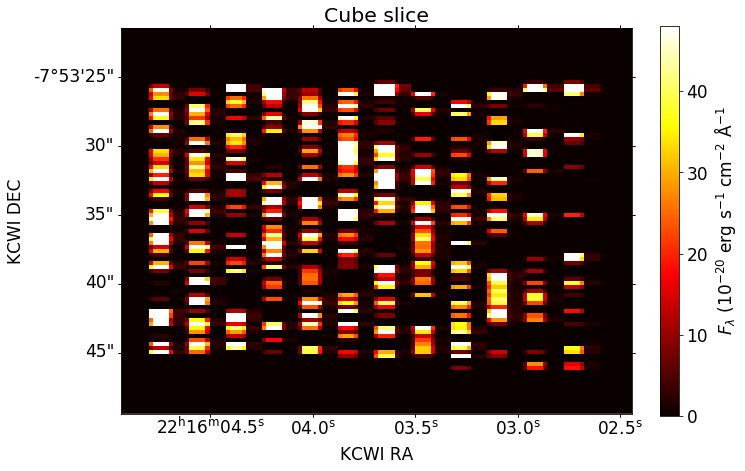

In [7]:
# Spatial slice
testslice = cube[100,:, :]
fig, ax = imshow_astro(testslice.value, spat_wcs, cblabel = flam)
ax. set_title("Cube slice")
plt.show()

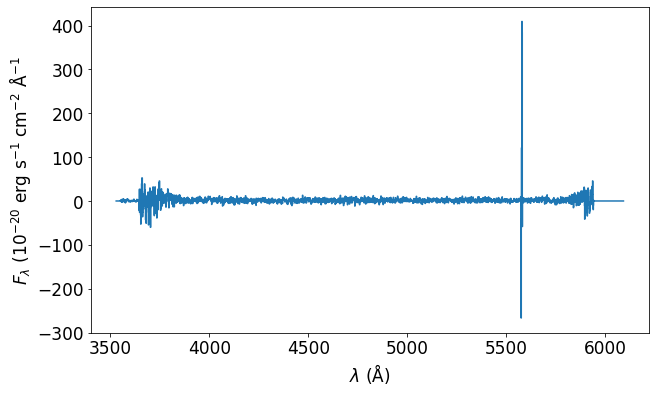

In [8]:
# Spectral ray
testray = cube[:, 50, 50]
plt.figure(figsize = (10,6))
plt.step(cube.spectral_axis, testray)
plt.xlabel(r"$\lambda~(\rm\AA)$")
plt.ylabel(flam)
#plt.xlim(5574, 5583)
plt.show()

From this spectrum, it looks like there are some bad wavelengths near 5500 A. I will mask this out before proceeding.
## Masking
Further inspection reveals the bad wavelengths are between 5575 A and 5582 A. To mask out a chunk of the cube, one must set the boolean values corresponding to that section to **False**. 

In [9]:
# Mask out bad wavelengths
badwave = (cube.spectral_axis > 5574*u.AA)&(cube.spectral_axis <5583*u.AA)
# Tile wavelength mask to fill the cube. This step is required because
# SpectralCube can't yet figure out how to tile a 1D mask.
goodwavemask = np.tile(~badwave, (cube.shape[2],cube.shape[1],1)).T

# Mask cubes
cube = cube.with_mask(goodwavemask)
varcube = varcube.with_mask(goodwavemask)

# write to files
if not os.path.isdir("/home/sunil/Desktop/FRB/190608/KCWI/masked"):
    os.mkdir("/home/sunil/Desktop/FRB/190608/KCWI/masked")
cube.write("/home/sunil/Desktop/FRB/190608/KCWI/masked/HG190608_5_icubes_masked.fits", overwrite=True)
varcube.write("/home/sunil/Desktop/FRB/190608/KCWI/masked/HG190608_5_vQubes_masked.fits", overwrite=True)

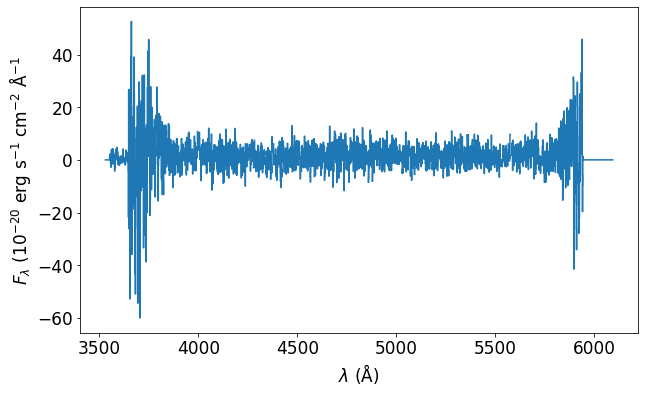

In [10]:
# Check masking:
testray = cube[:, 50, 50]
plt.figure(figsize = (10,6))
plt.step(cube.spectral_axis, testray)
plt.xlabel(r"$\lambda~(\rm\AA)$")
plt.ylabel(flam)
#plt.xlim(5574, 5583)
plt.show()

## Create a whitelight image

`kcwi.get_img` can produce a projection along the spectral axis. This projection can be simply between two wavelength limits or using a more complicated transmission curve (i.e. to produce synthetic photometry). Here, we only show the white light image.

In [11]:
help(kcwi.get_img)

Help on function get_img in module frb.analysis.kcwi:

get_img(cubefile, wlow=None, whigh=None, trans_curve=None, save=None, overwrite=False)
    Flatten cube along wavelength and produce a 2D
    image.
    Args:
        cubefile (str): Path to the datacube
        wlow, whigh (Quantity, optional): wavelength 
            limits (with astropy units) to flatten between.
            If nothing is given, the cube is checked for the
            WAVGOOD keywords and flattened between
            them. If they don't exist, it's flattened fully.
        filter (function, optional): transmission
            curve as a function of wavelength. Should be able
            to take vector inputs and produce vector outputs.
            We recommend passing a function produced by scipy
            interpolation method. Wavelength is assumed to
            be in angstroms.
        save (str, optional): Path to file to be
            saved to.
        overwrite (bool, optional): Overwrite existing
    

In [12]:
img = kcwi.get_img(cubefile)

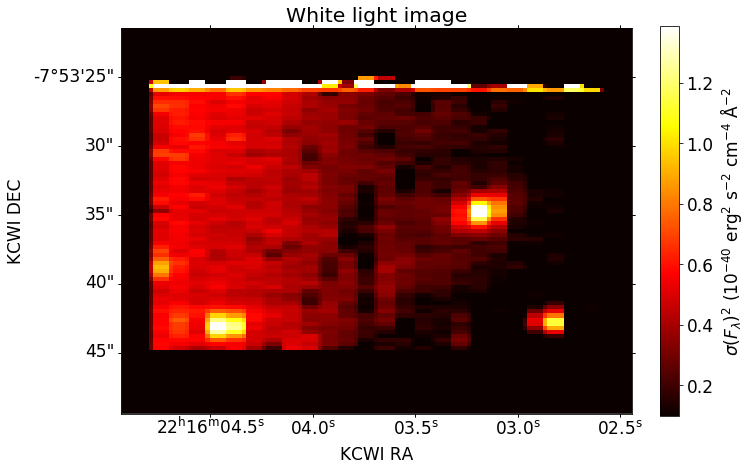

In [13]:
fig, ax = imshow_astro(img.value, img.wcs, cblabel = flam2)
ax.set_title("White light image")
plt.show()

/home/sunil/anaconda3/lib/python3.7/site-packages/radio_beam/multiple_beams.py:261: UserWarning: Do not use the average beam for convolution! Use the smallest common beam from `Beams.common_beam()`.
  warnings.warn("Do not use the average beam for convolution! Use the"


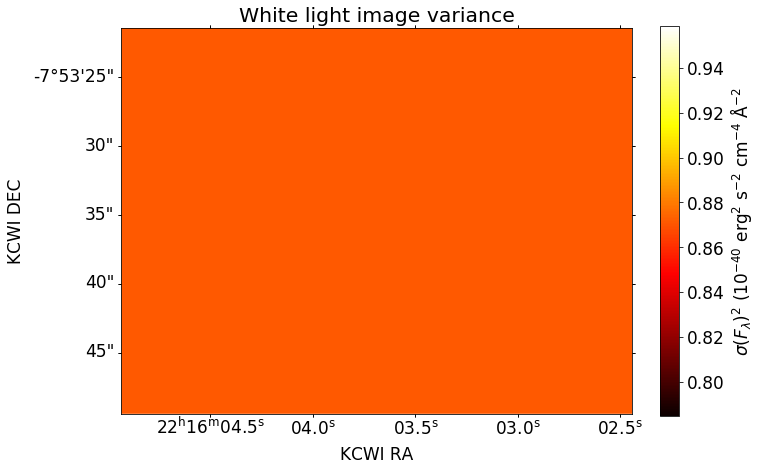

In [14]:
varimg = kcwi.get_img(varfile)
fig, ax = imshow_astro(varimg.value, varimg.wcs, cblabel=flam2)
ax.set_title("White light image variance")
plt.show()

## Extract spectrum using a spatial mask
One can use a 2D mask to extract a spectrum within that region. An intuitive way to do this would be to use PyRegion and create a mask from a `ds9.reg` file. 

In [15]:
regfile = "/home/sunil/Desktop/FRB/190608/KCWI/whitelight/test.reg"

reg = pyreg.open(regfile).as_imagecoord(img.header)
mask = reg.get_filter().mask(img.data)

mask.shape

(96, 127)

It is crucial that the masks are always boolean. **Using integer or float masks will make the process _very_ slow.**

In [16]:
mask.dtype

dtype('bool')

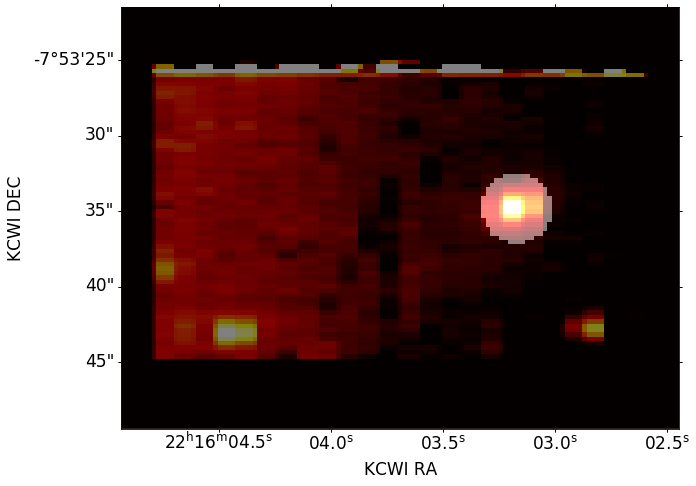

In [17]:
mask_vis = np.where(mask, 1, 0)
fig, ax = imshow_astro(img.value, img.wcs, colorbar = False)
im2 = ax.imshow(mask_vis, cmap ="Greys_r", alpha = 0.5)
plt.show()

In [18]:
# Get spectrum from the masked region
help(kcwi.spec_from_mask)

Help on function spec_from_mask in module frb.analysis.kcwi:

spec_from_mask(cube, mask_arr, varcube=None, kind='mean')
    Extract a spectrum from a cube
    within a mask.
    Args:
        cube (Spectral Cube): A datacube object
        mask_arr (numpy array): A 2D boolean array
        varcube (Spectral Cube, optional): Variance cube
        kind (str, optional): median or mean
    Returns:
        spec (OneDSpectrum): The extracted spectrum.
        var (OneDSpectrum): Variance in spectrum.
            Only returned if varcube is supplied.



In [20]:
spec, varspec = kcwi.spec_from_mask(cube,mask,varcube, kind = "mean")

/home/sunil/anaconda3/lib/python3.7/site-packages/spectral_cube/spectral_cube.py:597: RuntimeWarning: invalid value encountered in true_divide
  out = ttl / counts


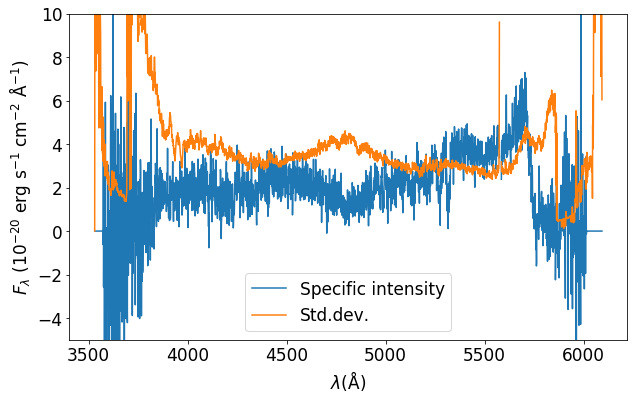

In [21]:
plt.figure(figsize = (10,6))
plt.plot(cube.spectral_axis, spec, label = "Specific intensity")
plt.plot(cube.spectral_axis, np.sqrt(varspec.data), label = "Std.dev.")
plt.legend()
plt.xlabel(r"$\lambda (\rm \AA)$")
plt.ylabel(r"$F_\lambda$ $\rm (10^{-20}\ erg\ s^{-1}\ cm^{-2}\ \AA^{-1})$")
plt.ylim(-5, 10)
plt.show()

## Get spectra from elliptical masks 
This is a thin wrapper around the `spec_from_mask` function because ellipses are so ubiquitous.

In [22]:
help(kcwi.spec_from_ellipse)

Help on function spec_from_ellipse in module frb.analysis.kcwi:

spec_from_ellipse(cube, varcube=None, x0=0.0, y0=0.0, a=1.0, b=1.0, theta=0.0, r=1.0)
    Get the spectrum within an elliptical region
    Args:
        cube (Spectral Cube): A datacube object
        varcube (Spectral Cube, optional): Variance cube
        x0, y0 (float, optional): Centroid of ellipse
        a, b (float, optional): semi-major and semi-minor axes
        theta (float, optional): rotation angle of the semi-major
            axis from the positive x axis.
        r (float, optional): Scaling factor for a and b.
            If not 1, a = r*a and b = r*b. 
    Returns:
        spec (OneDSpectrum): The extracted spectrum.
        var (OneDSpectrum): Variance in spectrum.
            Only returned if varcube is supplied.



In [23]:
# Visualize elliptical aperture
aperpos_sky = SkyCoord("22h16m3.18s", "-7d53m35s")
a, b = 3*u.arcsec, 2*u.arcsec
rot = -60*u.deg
skyaper = SkyEllipticalAperture(aperpos_sky, a, b, rot)
aper = skyaper.to_pixel(img.wcs)

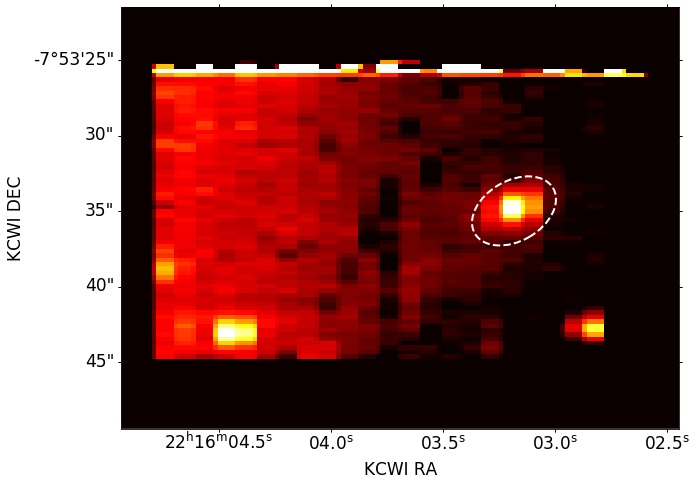

In [24]:
fig, ax = imshow_astro(img.value, img.wcs, colorbar = False)
aper.plot(ax, color="w", lw =2, ls="--")
plt.show()

In [25]:
# How is aper defined?
aper

<EllipticalAperture([88.84666254, 49.08974711], a=10.293148865976217, b=6.862099243984145, theta=0.5235987755783365)>

/home/sunil/anaconda3/lib/python3.7/site-packages/spectral_cube/spectral_cube.py:597: RuntimeWarning: invalid value encountered in true_divide
  out = ttl / counts


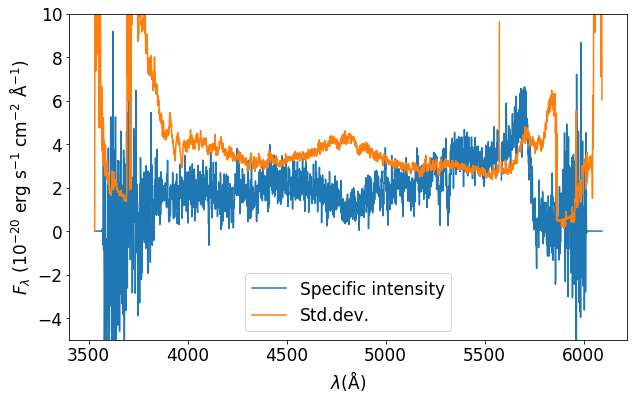

In [26]:
# Get spectrum using aper
x0, y0 = aper.positions
spec, varspec =  kcwi.spec_from_ellipse(cube, varcube, x0, y0 , aper.a, aper.b, aper.theta)

plt.figure(figsize = (10,6))
plt.plot(cube.spectral_axis, spec.data, label = "Specific intensity")
plt.plot(cube.spectral_axis, np.sqrt(varspec.data), label = "Std.dev.")
plt.legend()
plt.xlabel(r"$\lambda (\rm \AA)$")
plt.ylabel(r"$F_\lambda$ $\rm (10^{-20}\ erg\ s^{-1}\ cm^{-2}\ \AA^{-1})$")
plt.ylim(-5, 10)
plt.show()

## Find sources in an image
This is a wrapper for SExtractor's `extract` function. I'm passing a ds9 region file to exclude the edges from analysis.

In [27]:
help(kcwi.find_sources)

Help on function find_sources in module frb.analysis.kcwi:

find_sources(imgfile, nsig=1.5, minarea=10.0, clean=True, deblend_cont=0.0001, regfile=None, write=None, bkgsub=True)
    Find sources in the whitelight image
    using SExtractor.
    Args:
        imgfile (str): An image fits file
        n_sig (float, optional): Detection threshold in units
            of sky background rms.
        minarea (float, optional): minimum area in pixels
            to be considered a valid detection.
        clean (bool, optional): Perform cleaning?
        deblend_cont (float, optional): Minimum contrast ratio
            used for object deblending. Default is 0.005.
            To entirely disable deblending, set to 1.0.
        regfile (str, optional): A ds9 region file of
            areas to be masked out.
        write (str, optional): write extracted object table
            to this path.
        bkgsub (bool, optional): perform background subtraction?
            Default is set to true.


In [28]:
imgfile = "/home/sunil/Desktop/FRB/190608/KCWI/whitelight/HG190608_5_white.fits"
regfile = "/home/sunil/Desktop/FRB/190608/KCWI/whitelight/ds9.reg"
img = kcwi.get_img(cubefile)
img.write(imgfile, overwrite=True)

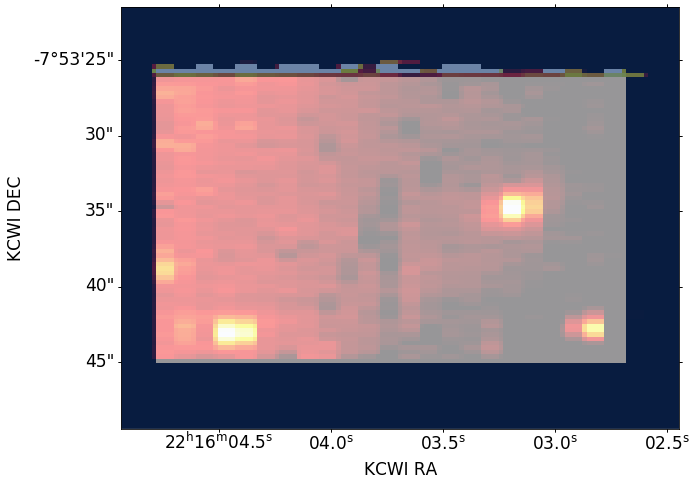

In [29]:
# Only the light region is accepted for analysis
reg = pyreg.open(regfile).as_imagecoord(img.header)
mask = reg.get_filter().mask(img.data)
mask_vis = np.where(mask, 0, 1)
fig, ax = imshow_astro(img.value, img.wcs, colorbar = False)
im2 = ax.imshow(mask_vis, cmap ="Blues_r", alpha = 0.6)
plt.show()

In [30]:
objects, segmap = kcwi.find_sources(imgfile,regfile = regfile, nsig=1.5, minarea=5)

In [31]:
objects

thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64
0.18415914475917816,73,72,21,30,18,25,25.379816248597788,21.57142836168336,6.833448755753672,3.100667399590302,0.2012950871474679,0.0,0.0,0.0,2.6161561012268066,1.7577950954437256,0.053718652576208115,0.14661937952041626,0.32312914729118347,-0.01903703808784485,34.73041915893555,36.64462661743164,0.8396795392036438,0.8971853852272034,24,21,25,21,0
0.18415914475917816,55,53,101,110,20,26,106.10752378840645,22.695881908278583,5.070422267768716,2.3749463585602015,-0.06744759029191627,0.0,0.0,0.0,2.252134323120117,1.5405387878417969,-0.025001658126711845,0.19729676842689514,0.4212212562561035,0.0112063093110919,27.316566467285156,29.41777992248535,1.0106792449951172,1.078481674194336,108,22,109,22,0
0.18415914475917816,11,11,8,11,35,37,9.645959195522376,35.90731821966526,1.0305557082998096,0.6013457838445269,0.11705310322688267,0.0,0.0,0.0,1.0297585725784302,0.7559754252433777,0.24966591596603394,0.9922888278961182,1.7005339860916138,-0.38630181550979614,2.6827385425567627,3.1963746547698975,0.29666417837142944,0.32068172097206116,10,36,11,36,0
0.18415914475917816,150,144,82,96,45,56,89.33909424849666,49.90698464505708,12.211342292745286,6.325254899476942,1.6444849522688543,0.0,0.0,0.0,3.555224895477295,2.428368330001831,0.2547757923603058,0.08486228436231613,0.16383251547813416,-0.04412620887160301,75.7061767578125,77.20582580566406,1.2767677307128906,1.3287640810012817,89,50,90,50,0


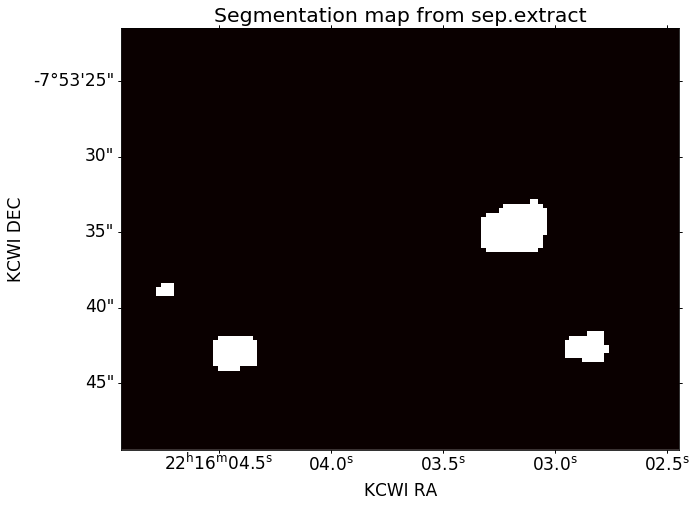

In [32]:
fig,ax = imshow_astro(segmap, img.wcs, colorbar=False, vrange= (0,1))
ax.set_title("Segmentation map from sep.extract")
plt.show()

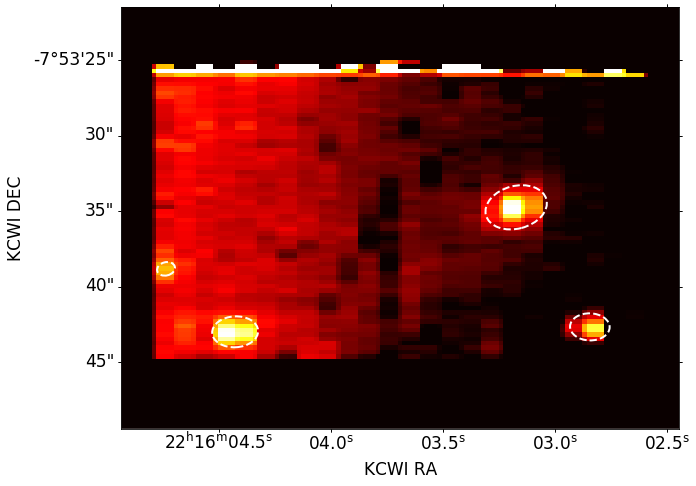

In [33]:
# Visualise the ellipses that extract has returned.
fig, ax = imshow_astro(img.value, img.wcs, colorbar = False)
for obj in objects:
    aper = EllipticalAperture((obj['x'], obj['y']), 2*obj['a'], 2*obj['b'], obj['theta'])
    aper.plot(ax, color="w", lw=2, ls="--")
plt.show()

## Extract spectra and create a MARZ input file
The final step is to get spectra of the identified sources and to create a MARZ input file.

In [34]:
reload(kcwi)

<module 'frb.analysis.kcwi' from '/home/sunil/Python/FRB/frb/analysis/kcwi.py'>

In [35]:
help(kcwi.get_source_spectra)

Help on function get_source_spectra in module frb.analysis.kcwi:

get_source_spectra(cubefile, varfile, objects, outdir='spectra/', marzfile=None, tovac=True)
    Extract spectra of sources found using SExtractor
    from datacube.
    Args:
        cubefile (str): A datacube fits file
        varfile (str): Variance datacube fits file
        objects (Table): Table of extracted objects produced
            by sep.extract
        outdir (str, optional): directory to store spectra
        marzfile (str, optional): name of MARZ file to dump
            all spectra into. File creation is skipped if
            a name is not supplied.
    Returns:
        speclist (ndarray): A 2D array of with an extracted
            spectrum in each row.
        varspeclist (ndarray): Similarly designed array with
            variance information.
        wave (1D Quantity array): Wavelength array.



In [39]:
reload(kcwi)

<module 'frb.analysis.kcwi' from '/home/sunil/Python/FRB/frb/analysis/kcwi.py'>

In [40]:
cubefile = "/home/sunil/Desktop/FRB/190608/KCWI/masked/HG190608_5_icubes_masked.fits"
varcubefile = "/home/sunil/Desktop/FRB/190608/KCWI/masked/HG190608_5_vQubes_masked.fits"
outdir = "/home/sunil/Desktop/FRB/190608/KCWI/HG_5_spectra/"
marzfile = "HG_5_marz.fits"
speclist, varspeclist, wave = kcwi.get_source_spectra(cubefile, varfile, objects,outdir = outdir, marzfile=marzfile)

/home/sunil/anaconda3/lib/python3.7/site-packages/spectral_cube/spectral_cube.py:597: RuntimeWarning: invalid value encountered in true_divide
  out = ttl / counts
/home/sunil/anaconda3/lib/python3.7/site-packages/spectral_cube/spectral_cube.py:597: RuntimeWarning: invalid value encountered in true_divide
  out = ttl / counts
/home/sunil/anaconda3/lib/python3.7/site-packages/spectral_cube/spectral_cube.py:597: RuntimeWarning: invalid value encountered in true_divide
  out = ttl / counts
/home/sunil/anaconda3/lib/python3.7/site-packages/spectral_cube/spectral_cube.py:597: RuntimeWarning: invalid value encountered in true_divide
  out = ttl / counts


In [41]:
# All outputs
sorted(glob.glob(outdir+"*.fits"))

['/home/sunil/Desktop/FRB/190608/KCWI/HG_5_spectra/0_spec1d.fits',
 '/home/sunil/Desktop/FRB/190608/KCWI/HG_5_spectra/1_spec1d.fits',
 '/home/sunil/Desktop/FRB/190608/KCWI/HG_5_spectra/2_spec1d.fits',
 '/home/sunil/Desktop/FRB/190608/KCWI/HG_5_spectra/3_spec1d.fits',
 '/home/sunil/Desktop/FRB/190608/KCWI/HG_5_spectra/HG_5_marz.fits']

In [42]:
# Look at the contents of the MARZ file
marzhdus = fits.open("/home/sunil/Desktop/FRB/190608/KCWI/HG_5_spectra/HG_5_marz.fits")
marzhdus.info()

Filename: /home/sunil/Desktop/FRB/190608/KCWI/HG_5_spectra/HG_5_marz.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  INTENSITY     1 PrimaryHDU       7   (2563, 4)   float64   
  1  VARIANCE      1 ImageHDU         8   (2563, 4)   float64   
  2  SKY           1 ImageHDU         8   (2563, 4)   float64   
  3  WAVELENGTH    1 ImageHDU         8   (2563, 4)   float64   
  4  FIBRES        1 BinTableHDU     21   4R x 6C   [80A, D, D, J, J, 1A]   
